# Projeto 07 -  Medicina Personalizada - Redefinindo o Tratamento de Câncer

https://www.kaggle.com/c/msk-redefining-cancer-treatment/

Conforme desafio do Kaggle, criei um modelo para classificar automaticamente variações genéticas. Utilizei Deep Learning como técnica de modelagem preditiva. Nesse notebook não utilizei as bases completas por se tratar de um estudo de caso.

In [1]:
# Importação de bibliotecas
import pandas as pd # Manipulação com dataframes
import numpy as np # Manipulação e tratamento de dados
import matplotlib.pyplot as plt # data viz
import seaborn as sns # data viz
sns.set(style="ticks")
import string # Aplicações com strings
import re # Regex
from nltk.corpus import stopwords # stopwords para PLN
from nltk.stem import LancasterStemmer # Stemming para PLN
from nltk.tokenize import RegexpTokenizer # Tokenizar por expressões regulares
from sklearn.feature_extraction.text import TfidfVectorizer # term frequency–inverse document frequency
from keras.models import Sequential # modelo deep learning
from keras.layers import Dense # modelo  ''
from keras.optimizers import SGD # modelo ''
import warnings 
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
# Carregando os datasets
train_text = pd.read_csv("data_files/training_text", sep = "\|\|")
train_variants = pd.read_csv("data_files/training_variants")

test_text = pd.read_csv("data_files/test_text", sep = "\|\|")
test_variants = pd.read_csv("data_files/test_variants")

In [3]:
# Visualizando os dados de treino train_text
train_text.head()

,ID,Text
0,0,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,Abstract Background Non-small cell lung canc...
2,2,Abstract Background Non-small cell lung canc...
3,3,Recent evidence has demonstrated that acquired...
4,4,Oncogenic mutations in the monomeric Casitas B...


In [4]:
# Visualizando os dados de treino train_variants
train_variants.head()

,ID,Gene,Variation,Class
0,0,FAM58A,Truncating Mutations,1
1,1,CBL,W802*,2
2,2,CBL,Q249E,2
3,3,CBL,N454D,3
4,4,CBL,L399V,4


In [5]:
# Juntando as duas tabelas
df_train = pd.merge(train_text, train_variants, how='left', on='ID')
df_test = pd.merge(test_text, test_variants, how='left', on='ID')
df_train.head()

,ID,Text,Gene,Variation,Class
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4


In [6]:
# Transformando colunas numéricas em categóricas 
df_train[['ID','Class']] = df_train[['ID','Class']].astype(str)

# Dimensão do dataframe e o tipo das colunas
print("Linhas e colunas: " + str(df_train.shape) + '\n')
print("Data types: \n" + str(df_train.dtypes))

Linhas e colunas: (139, 5)

Data types: 
ID           object
Text         object
Gene         object
Variation    object
Class        object
dtype: object


In [7]:
# Sumário dos dados
df_train.describe()

,ID,Text,Gene,Variation,Class
count,139,139,139,139,139
unique,139,87,23,120,9
top,38,Oncogenic mutations in the monomeric Casitas B...,CBL,Deletion,4
freq,1,8,25,9,53


In [8]:
# Checando se há valores missing
df_train.isna().sum()

ID           0
Text         0
Gene         0
Variation    0
Class        0
dtype: int64

#### Análise exploratória:

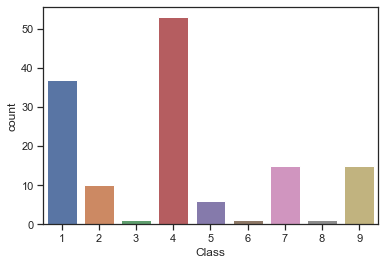

In [9]:
# Analisando variável target
sns.countplot(x="Class", data=df_train)

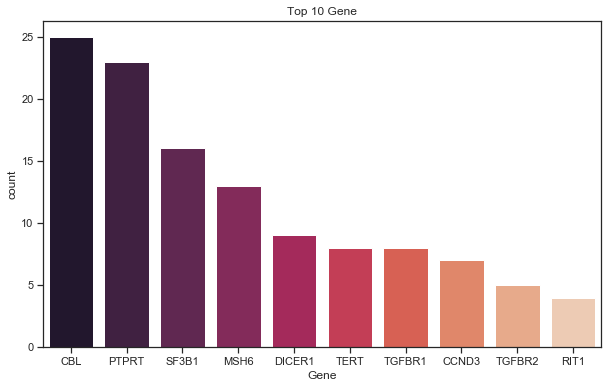

In [29]:
# Contagem Top 10 Gene 
plt.figure(figsize=(10,6))
ax = sns.countplot(x="Gene", data=df_train, order=df_train['Gene'].value_counts().iloc[:10].index, palette="rocket")
ax.set_title('Top 10 Gene')
plt.show()

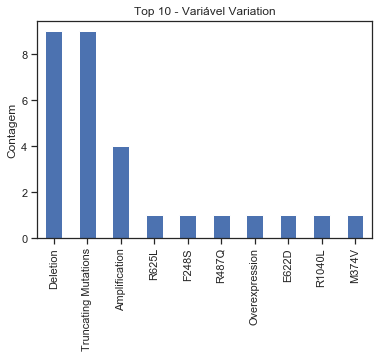

In [30]:
# Variation (the aminoacid change for this mutations) 
ax = df_train['Variation'].value_counts().iloc[:10].plot(kind="bar")
ax.set_ylabel("Contagem")
ax.set_title("Top 10 - Variável Variation")
plt.show()

#### Algumas conclusões dos dados de treino ✅

- Classes: É possível visualizar que as maiores proporções das classes estão entre 4 e 1.

- Gene: Cerca de 60% dos Genes estão concentrados em: CBL, PTPRT, SF3B1, MSH6.

- Variation: As categorias desse atributo são praticamente únicas. Podemos estudar as particularidades das 3 primeiras categorias, mas provalmente essa variável não será usada para previsões.

Na próxima vou explorar a variável 'Text' que precisa tratamento de texto para análise.

#### Análise exploratória e pré-processamento  - Variável 'Text'

In [12]:
## Pré-processamento dos dados / Feature engineering

# criar coluna Class p/ df teste
df_test.insert(4,column= 'Class', value= -1) 

# Juntar dataframes de treino e teste 
df_final = df_train.append(df_test, ignore_index=True) #ignore_index para não termos index duplicados

# criando coluna com contagem de palavras
df_final['count_words'] = df_final.Text.apply(lambda x: len(x.split(' '))) # criando coluna com contagem de palavras

# criando coluna de label treino/teste
df_final['data'] = df_final.Class.apply(lambda x: 'Teste' if x == -1 else 'Treino')

df_final.head()

,ID,Text,Gene,Variation,Class,count_words,data
0,0,Cyclin-dependent kinases (CDKs) regulate a var...,FAM58A,Truncating Mutations,1,6105,Treino
1,1,Abstract Background Non-small cell lung canc...,CBL,W802*,2,5783,Treino
2,2,Abstract Background Non-small cell lung canc...,CBL,Q249E,2,5783,Treino
3,3,Recent evidence has demonstrated that acquired...,CBL,N454D,3,5625,Treino
4,4,Oncogenic mutations in the monomeric Casitas B...,CBL,L399V,4,6248,Treino


Total de palavras treino/teste: 
data
Teste     1272023
Treino    1272023
Name: count_words, dtype: int64

 Média de palavras: 9151
 Menor nr de palavras: 1


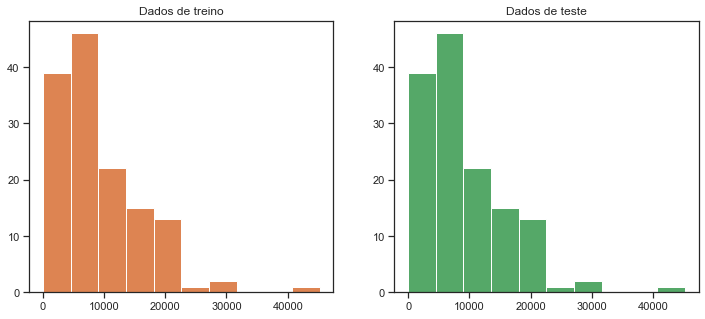

In [13]:
## Análise do texto

# Sumarização de alguns dados do atributo 'Text'
print("Total de palavras treino/teste: \n" + str(df_final.groupby("data").count_words.sum()))
print("\n Média de palavras: " + str(int(df_final.count_words.mean())))
print(" Menor nr de palavras: " + str(df_final.count_words.min()))

# Coletando as count_words de treino e teste 
x1 = df_final.loc[df_final.data=='Treino', 'count_words']
x2 = df_final.loc[df_final.data=='Teste', 'count_words']

# Plotando os gráficos
fig, axs = plt.subplots(1, 2, figsize=(12,5))
axs[0].hist(x1, color='C1')
axs[1].hist(x2, color = 'C2')
axs[0].set_title('Dados de treino')
axs[1].set_title('Dados de teste')
plt.show()

Nota-se que a quantidade de palavras tanto para conjunto de treino quanto de teste é a mesma, assim como sua distribuição.

Um fato importante é que o dataset possui pelo menos um texto com apenas 1 palavra. Será necessário remover esse registro pois aparentemente é um erro. 

In [14]:
# Contagem de casos com 10 palavras ou menos
print("Casos <= 10 palavras: " + str((df_final.count_words <= 10).sum()))

# Removendo casos com texto com menos de 10 palavras.
df_final = df_final[df_final.count_words > 10]

# Após remoção
print("Novo mínimo nr de palavras após tratamento: " + str(df_final.count_words.min()))

Casos <= 10 palavras: 2
Novo mínimo nr de palavras após tratamento: 1153


In [15]:
## Processamento de texto

# Criando função para tratamento do texto
english_stops = set(stopwords.words('english'))
lanc_stemmer = LancasterStemmer()

def text_transform(text):
    
    text = text.translate(str.maketrans('', '', string.punctuation)).lower() #Punctuation / lowercase
    text = [word for word in text.split() if word not in english_stops] # separando as palavras e removendo stopwords
    text = [lanc_stemmer.stem(word) for word in text] # Stemming
    text = [word for word in text if not word.isnumeric()] # removendo apenas números
    new_text = ' '.join(text) # juntando o texto novamente
    
    return new_text

# Aplicando a função de transformação dos dados
X = df_final.Text.apply(text_transform)
print(X)

0      cyclindepend kinas cdks reg vary funda cellul ...
1      abstract background nonsmal cel lung cant nscl...
2      abstract background nonsmal cel lung cant nscl...
3      rec evid demonst acquir unip disom aupd novel ...
4      oncog mut monom casita blin lymphom cbl gen fo...
                             ...                        
272    rna mat import complex biolog process requir s...
273    splicing fact sf3b1 common mut gen myelodyspla...
274    mut gen encod protein involv rna splicing foun...
275    precurs mrna splicing catalys spliceosome macr...
276    malign mesotheliom mm aggress neoplasm assocy ...
Name: Text, Length: 276, dtype: object


In [16]:
# Criando a tf-idf 
tfidf = TfidfVectorizer().fit_transform(X) # criando tfidf matrix
tfidf=  tfidf.toarray() # transformando para array
tfidf.shape # dimensões 

(276, 27703)

In [17]:
# OneHot enconding - Variável Gene
X_Gene = pd.get_dummies(df_final.Gene)
X_Gene

,ABCA1,ABCA12,ABCA4,ABCD1,ACADS,ACOX1,ACSL4,AGXT,ARSA,ATM,...,TSC1,TSHR,TYR,UBE3A,UMOD,UROS,VCP,VHL,VWF,ZFPM2
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
273,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
274,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Concatena tf-idf e X_Gene criados com variáveis 'data' e 'Class' em uma matrix
X = np.column_stack(list([tfidf, X_Gene, df_final['data'], df_final['Class']])) # junta por nivel de coluna

# Preparação de X e Y (features e target)
train = X[df_final['data'] == 'Treino'] # Separa dados de treino
X_train = train[:,:-2] # prepara as variáveis de entrada, removendo as duas ultimas colunas
Y_train = train[:,-1] # pegando a última coluna onde estão as classes
Y_train_encoded = pd.get_dummies(Y_train) # onehot enconding para classes (necessário para meu modelo)

# Agora para teste
test = X[df_final['data'] == 'Teste'] # Separa dados de teste
X_test = test[:,:-2] # prepara as variáveis de entrada, removendo as duas ultimas colunas

print("Dimensões dos dados de entrada: " + str(X_train.shape))
print("Dimensões : " + str(Y_train_encoded.shape))

Dimensões dos dados de entrada: (138, 27845)
Dimensões : (138, 9)


#### Criação do modelo de Deep Learning 

In [19]:
# Cria o modelo
model = Sequential()
model.add(Dense(12, input_dim = 27845, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(8, kernel_initializer = 'uniform', activation = 'relu'))
model.add(Dense(9, activation = 'sigmoid', kernel_initializer = 'uniform'))


# Compila o modelo - com otimizador Stochastic Gradient Descent
model.compile(loss = 'categorical_crossentropy', 
              optimizer = SGD(lr = 0.01, momentum = 0.9, nesterov = True), 
              metrics = ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12)                334152    
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 81        
Total params: 334,337
Trainable params: 334,337
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Executa o modelo e valida nos mesmos dados em que foi criado (treino)
model.fit(X_train, Y_train_encoded, epochs = 300, batch_size = 10)

Epoch 1/300
138/138 [==============================] - 0s 2ms/step - loss: 2.1881 - accuracy: 0.3551
Epoch 2/300
138/138 [==============================] - 0s 1ms/step - loss: 2.1541 - accuracy: 0.3841
Epoch 3/300
138/138 [==============================] - 0s 1ms/step - loss: 2.1177 - accuracy: 0.3841
Epoch 4/300
138/138 [==============================] - 0s 1ms/step - loss: 2.0835 - accuracy: 0.3841
Epoch 5/300
138/138 [==============================] - 0s 1ms/step - loss: 2.0544 - accuracy: 0.3841
Epoch 6/300
138/138 [==============================] - 0s 1ms/step - loss: 2.0276 - accuracy: 0.3841
Epoch 7/300
138/138 [==============================] - 0s 1ms/step - loss: 2.0035 - accuracy: 0.3841
Epoch 8/300
138/138 [==============================] - 0s 1ms/step - loss: 1.9813 - accuracy: 0.3841
Epoch 9/300
138/138 [==============================] - 0s 1ms/step - loss: 1.9622 - accuracy: 0.3841
Epoch 10/300
138/138 [==============================] - 0s 1ms/step - loss: 1.9428 - accura

Epoch 81/300
138/138 [==============================] - 0s 1ms/step - loss: 1.4500 - accuracy: 0.3841
Epoch 82/300
138/138 [==============================] - 0s 1ms/step - loss: 1.4321 - accuracy: 0.3841
Epoch 83/300
138/138 [==============================] - 0s 1ms/step - loss: 1.4140 - accuracy: 0.3841
Epoch 84/300
138/138 [==============================] - 0s 1ms/step - loss: 1.4004 - accuracy: 0.3841
Epoch 85/300
138/138 [==============================] - 0s 1ms/step - loss: 1.3903 - accuracy: 0.3841
Epoch 86/300
138/138 [==============================] - 0s 1ms/step - loss: 1.3795 - accuracy: 0.3841
Epoch 87/300
138/138 [==============================] - 0s 1ms/step - loss: 1.3692 - accuracy: 0.3841
Epoch 88/300
138/138 [==============================] - 0s 1ms/step - loss: 1.3580 - accuracy: 0.3841
Epoch 89/300
138/138 [==============================] - 0s 1ms/step - loss: 1.3476 - accuracy: 0.3841
Epoch 90/300
138/138 [==============================] - 0s 1ms/step - loss: 1.3376

138/138 [==============================] - 0s 1ms/step - loss: 0.4934 - accuracy: 0.7609
Epoch 161/300
138/138 [==============================] - 0s 1ms/step - loss: 0.4906 - accuracy: 0.7754
Epoch 162/300
138/138 [==============================] - 0s 1ms/step - loss: 0.4865 - accuracy: 0.7899
Epoch 163/300
138/138 [==============================] - 0s 1ms/step - loss: 0.4774 - accuracy: 0.7681
Epoch 164/300
138/138 [==============================] - 0s 1ms/step - loss: 0.4851 - accuracy: 0.7754
Epoch 165/300
138/138 [==============================] - 0s 1ms/step - loss: 0.4812 - accuracy: 0.7681
Epoch 166/300
138/138 [==============================] - 0s 1ms/step - loss: 0.4454 - accuracy: 0.7609
Epoch 167/300
138/138 [==============================] - 0s 1ms/step - loss: 0.4475 - accuracy: 0.7971
Epoch 168/300
138/138 [==============================] - 0s 1ms/step - loss: 0.4535 - accuracy: 0.7754
Epoch 169/300
138/138 [==============================] - 0s 1ms/step - loss: 0.4347 - a

138/138 [==============================] - 0s 1ms/step - loss: 0.3474 - accuracy: 0.7826
Epoch 240/300
138/138 [==============================] - 0s 1ms/step - loss: 0.3771 - accuracy: 0.7899
Epoch 241/300
138/138 [==============================] - 0s 1ms/step - loss: 0.3686 - accuracy: 0.7754
Epoch 242/300
138/138 [==============================] - 0s 1ms/step - loss: 0.4119 - accuracy: 0.7899
Epoch 243/300
138/138 [==============================] - 0s 1ms/step - loss: 0.3567 - accuracy: 0.7826
Epoch 244/300
138/138 [==============================] - 0s 1ms/step - loss: 0.3631 - accuracy: 0.7899
Epoch 245/300
138/138 [==============================] - 0s 1ms/step - loss: 0.3200 - accuracy: 0.7826
Epoch 246/300
138/138 [==============================] - 0s 1ms/step - loss: 0.3037 - accuracy: 0.8043
Epoch 247/300
138/138 [==============================] - 0s 1ms/step - loss: 0.3383 - accuracy: 0.7754
Epoch 248/300
138/138 [==============================] - 0s 1ms/step - loss: 0.3465 - a

In [21]:
# Avalia os resultados do modelo
scores = model.evaluate(X_train, Y_train_encoded)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

138/138 [==============================] - 0s 905us/step
accuracy: 78.99%


In [22]:
# Compila o modelo com outro otimizador: Adam Gradient Descent algorithm
model.compile(loss = 'categorical_crossentropy', 
              optimizer = 'adam', 
              metrics = ['accuracy'])

# Executa o modelo e valida nos mesmos dados em que foi criado (treino)
model.fit(X_train, Y_train_encoded, epochs = 200, batch_size = 5)

Epoch 1/200
138/138 [==============================] - 0s 3ms/step - loss: 0.2525 - accuracy: 0.8043
Epoch 2/200
138/138 [==============================] - ETA: 0s - loss: 0.2417 - accuracy: 0.81 - 0s 2ms/step - loss: 0.2409 - accuracy: 0.8188
Epoch 3/200
138/138 [==============================] - 0s 2ms/step - loss: 0.2452 - accuracy: 0.7971
Epoch 4/200
138/138 [==============================] - 0s 2ms/step - loss: 0.2374 - accuracy: 0.8043
Epoch 5/200
138/138 [==============================] - 0s 2ms/step - loss: 0.2424 - accuracy: 0.7899
Epoch 6/200
138/138 [==============================] - 0s 2ms/step - loss: 0.2303 - accuracy: 0.7971
Epoch 7/200
138/138 [==============================] - 0s 2ms/step - loss: 0.2378 - accuracy: 0.8188
Epoch 8/200
138/138 [==============================] - 0s 2ms/step - loss: 0.2308 - accuracy: 0.8043
Epoch 9/200
138/138 [==============================] - 0s 2ms/step - loss: 0.2337 - accuracy: 0.7971
Epoch 10/200
138/138 [===========================

138/138 [==============================] - 0s 2ms/step - loss: 0.1422 - accuracy: 0.9275
Epoch 81/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1344 - accuracy: 0.9203
Epoch 82/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1357 - accuracy: 0.8986
Epoch 83/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1312 - accuracy: 0.9203
Epoch 84/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1350 - accuracy: 0.9203
Epoch 85/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1365 - accuracy: 0.9203
Epoch 86/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1312 - accuracy: 0.9130
Epoch 87/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1341 - accuracy: 0.9203
Epoch 88/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1385 - accuracy: 0.9058
Epoch 89/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1271 - accuracy: 

138/138 [==============================] - 0s 2ms/step - loss: 0.1320 - accuracy: 0.9130
Epoch 160/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1378 - accuracy: 0.9203
Epoch 161/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1310 - accuracy: 0.9275
Epoch 162/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1314 - accuracy: 0.9203
Epoch 163/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1468 - accuracy: 0.8768
Epoch 164/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1362 - accuracy: 0.9058
Epoch 165/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1345 - accuracy: 0.9058
Epoch 166/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1473 - accuracy: 0.9203
Epoch 167/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1366 - accuracy: 0.8986
Epoch 168/200
138/138 [==============================] - 0s 2ms/step - loss: 0.1310 - a

In [23]:
# Avalia os resultados do modelo
scores = model.evaluate(X_train, Y_train_encoded)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

138/138 [==============================] - 0s 932us/step
accuracy: 92.75%


In [24]:
# Prevendo as classes dos dados de teste
pred_class = model.predict_classes(X_test)
classes = np.array(range(1, 10))
preds = classes[pred_class]
preds

array([4, 2, 2, 4, 4, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 6, 4,
       5, 4, 4, 4, 4, 4, 7, 4, 4, 7, 4, 2, 7, 4, 4, 4, 4, 4, 4, 1, 4, 1,
       4, 1, 4, 1, 4, 4, 1, 1, 4, 1, 1, 1, 4, 1, 1, 4, 1, 4, 4, 4, 1, 1,
       4, 7, 7, 7, 1, 2, 1, 4, 1, 2, 2, 2, 2, 2, 2, 2, 7, 7, 4, 7, 7, 7,
       4, 4, 1, 4, 4, 4, 1, 4, 4, 2, 4, 4, 1, 1, 4, 1, 4, 1, 5, 1, 1, 5,
       1, 5, 4, 4, 4, 1, 1, 4, 1, 1, 4, 9, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 4])

In [25]:
## Formatando no arquivo de submission

# Onehot encoding classes
preds_onehot = pd.get_dummies(preds)

# Criando df final de entrega 
df_submission = pd.concat([df_test['ID'][:-1], preds_onehot], axis = 1).astype(int)
df_submission

,ID,1,2,4,5,6,7,9
0,0,0,0,1,0,0,0,0
1,1,0,1,0,0,0,0,0
2,2,0,1,0,0,0,0,0
3,3,0,0,1,0,0,0,0
4,4,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
133,133,0,0,0,0,1,0,0
134,134,0,0,0,0,1,0,0
135,135,0,0,0,0,1,0,0
136,136,0,0,0,0,1,0,0


In [26]:
# Salvando arquivo de submissão
df_submission.to_csv('submission.csv', index=False)